<a href="https://colab.research.google.com/github/vanshgupta7/Deep_Pyramid_Convolution_Neural_Network/blob/master/DPCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPCNN Implementation

Source: https://aclanthology.org/P17-1052/ 

by: Saksham, Vansh and Rajarshi

In [ ]:
# Saksham Aggarwal = 2020A7PS1508P
# Vansh Gupta = 2020A7PS0315P
# Rajarshi Mishra = 2020A8PS1822P

In [ ]:
!pip install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import argparse
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
import math
import nltk
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=50)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:07<00:00, 50295.58it/s]


## Importing Kaggle Dataset

- Sign into your kaggle account
- Click on Create API key, it will download `kaggle.json`
- After running the below cell, you will be prompted to upload a file. Upload `kaggle.json` there.

In [ ]:
# Mount Google Drive files 
from google.colab import drive
drive.mount('/content/gdrive')

# Upload the kaggle.json file
from google.colab import files
files.upload()

# Install kaggle API client
!pip install -q kaggle

# kaggle API client expects the file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set permissions
!chmod 600 /root/.kaggle/kaggle.json

# download the required dataset from kaggle
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

# make neccesory folders and structure
!mkdir ./data && mkdir ./data/train && mkdir ./checkpoints && touch ./checkpoints/.placeholder

# unzip
!unzip news-headlines-dataset-for-sarcasm-detection.zip -d ./data/train

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
100% 3.30M/3.30M [00:01<00:00, 3.67MB/s]
100% 3.30M/3.30M [00:01<00:00, 2.73MB/s]
Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: ./data/train/Sarcasm_Headlines_Dataset.json  
  inflating: ./data/train/Sarcasm_Headlines_Dataset_v2.json  


## Setting the Configurations

In [ ]:
# Setting the seed
torch.manual_seed(1)

In [ ]:
class Config(object):
    def __init__(self, word_embedding_dimension=50, word_num=20000,
                 epoch=10, sentence_max_size=40,
                 learning_rate=0.09, batch_size=1,
                 drop_out=0.5,
                 dict_size=50000,
                 bidirectional=False,
                 doc_len=40):
        self.word_embedding_dimension = word_embedding_dimension
        self.word_num = word_num
        self.epoch = epoch
        self.sentence_max_size = sentence_max_size             
        self.lr = learning_rate
        self.batch_size = batch_size
        self.dict_size = dict_size
        self.drop_out = drop_out
        self.bidirectional = bidirectional
        self.doc_len = doc_len

config = Config()

## Preprocessing

In [ ]:
def clean_str_and_tokenise(line):
	# chars_to_remove = [',', '.', '"', "'", '/', '*', ',', '?', '!', '-', '\n', '“', '”', '_', '&', '\ufeff', '&', ';', ":"]
	# line = ''.join([c for c in line if c not in chars_to_remove])
	chars_to_remove = [',', '.', '"', "'", '/', '*', ',', '?', '!', '-', '\n', '“', '”', '_', '&', '\ufeff', '&', ';', ":"]
	for item in chars_to_remove:
		line = line.replace(item,'')
	
	line = line.lower()
	line = line.split(' ')
	return line

def pad_sequence(tokens, seq_len, padding_token = '<PAD>'):

	if len(tokens)>0:		
		if len(tokens) <=seq_len:
			last_token = tokens[-1]
		else:
			last_token = tokens[seq_len]
    
	else:
		last_token = ""

	tokens = tokens[:-1]
	if len(tokens) > seq_len:
		tokens = tokens[:seq_len]
	elif len(tokens) < seq_len:
		tokens.extend([padding_token]*(seq_len - len(tokens)))
	return tokens, last_token

def preprocess_data(path,seq_len):
	datapoints = []
	labels = []

	df = pd.read_json(path,lines=True)
 
	for i in range(len(df)):
		tokens = clean_str_and_tokenise(df['headline'][i])
		a = pad_sequence(tokens, seq_len)
		datapoints.append(a[0])
		labels.append(df['is_sarcastic'][i])
		# print(tokens)
	return datapoints, labels

In [ ]:
datapoints, labels = preprocess_data("./data/train/Sarcasm_Headlines_Dataset.json",40)
datapoints2, labels2 = preprocess_data("./data/train/Sarcasm_Headlines_Dataset_v2.json",40)

## Building the vocab and converting the tokens to numbers

In [ ]:
def build_vocab(datapoints, labels, vocab_size):
	'''
		Building the vocabulary from the most common words in the corpus

		Note: Ensure to leave a slot in the vocabulary for the <UNK> token. 
		For uniformity, insert this at the end of your vocab, ie, its index should be vocab_size-1.
		Also ensure that each label is in the vocab. If not, add it by removing the least common word.
		Also ensure you remove padding tokens from the vocabulary and add the most appropriate word.
		
		Arguments:
			datapoints: The preprocessed datapoints in the corpus
			labels: The labels per datapoint in the corpus
			vocab_size: The number of tokens in the vocab

		Returns:
			vocab: A dicitionary mapping from the word to its corresponding vocab index(0 indexed)
			vocab_inv: A dicitionary mapping from the vocab index to its corresponding word
	'''	

	word_sea = []
	for datapoint in datapoints:
		word_sea.extend(datapoint)
	for datapoint in labels:
		word_sea.append(datapoint)
	
	most_common_words = [word for word, _ in Counter(word_sea).most_common(vocab_size - 1)]
	replaced_idx = 1
	for label in labels:
		if label not in most_common_words:
			while(most_common_words[-replaced_idx] in labels):
				replaced_idx += 1
			most_common_words[-replaced_idx] = label
	
	vocab = {word: idx for idx, word in enumerate(most_common_words)}
	vocab_inv = {idx: word for idx, word in enumerate(most_common_words)}
	vocab['<UNK>'] = vocab_size - 1
	vocab_inv[vocab_size - 1] = '<UNK>'
	return vocab, vocab_inv


def data2tokens(vocab, raw_data):
	'''
		Converts the raw text into their corresponding tokens
		
		Arguments:
			vocab: Mapping from the word to its corresponding vocab index
			raw_data: The preprocessed data, however, some words are not present as 
							  tokens in the vocab

		Returns:
			dataset_tokens: A list of the preprocessed data where all words are correspoding to 
									    tokens in the vocab
	'''
	dataset_tokens = []
	for data in raw_data:
		dataset_tokens.append([word if word in vocab else '<UNK>' for word in data])
	
	return dataset_tokens


def tokens2ids(vocab, data_tokens):
	'''
		Converts the tokens into their corresponding vocab indices
		
		Arguments:
			vocab: Mapping from the word to its corresponding vocab index
			data_tokens: The preprocessed data where all words are correspoding to 
									 tokens in the vocab

		Returns:
			dataset_ids: The tokens in the dataset converted to their vocab indices
			This should be a Pytorch Long Tensor
	'''
	# YOUR CODE HERE
	dataset_ids = [[vocab[line] for line in lines] for lines in data_tokens]
	dataset_ids = torch.tensor(dataset_ids, dtype=torch.long)
 
	return dataset_ids

In [ ]:
vocab, vocab_inv = build_vocab(datapoints, labels, vocab_size=10000)
dataset_tokens = data2tokens(vocab, datapoints)
dataset_ids = tokens2ids(vocab, dataset_tokens)

vocab2, vocab_inv2 = build_vocab(datapoints2, labels2, vocab_size=10000)
dataset_tokens2 = data2tokens(vocab2, datapoints2)
dataset_ids2 = tokens2ids(vocab2, dataset_tokens2)

## Building the Model and Dataset

In [ ]:
# Dataset
import os
import json
import torch.utils.data as data
  
class TextSet(data.Dataset):
    def __init__(self, path):
        self.file_name = os.listdir(path)

        df = pd.read_json(path + "/" + self.file_name[1], lines=True)
        self.train = df

    def __getitem__(self, index):
        return global_vectors.get_vecs_by_tokens(dataset_tokens[index], lower_case_backup=True), self.train['is_sarcastic'][index]

    def __len__(self):
        return len(self.train)


training_set = TextSet(path='data/train')
training_iter = data.DataLoader(dataset=training_set, batch_size=config.batch_size, num_workers=2)

In [ ]:
import os
import json
import torch.utils.data as data
class TextSet2(data.Dataset):
    def __init__(self, path):
        self.file_name = os.listdir(path)

        df = pd.read_json(path + "/" + self.file_name[0], lines=True)
        self.train = df

    def __getitem__(self, index):
        return global_vectors.get_vecs_by_tokens(dataset_tokens2[index], lower_case_backup=True), self.train['is_sarcastic'][index]

    def __len__(self):
        return len(self.train)
test_set = TextSet2(path='data/train')
test_iter = data.DataLoader(dataset=test_set, batch_size=config.batch_size, num_workers=2)
print(test_set.train.shape)

(28619, 3)


In [ ]:
# DPCNN

class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)
    
class DPCNN(BasicModule):  
    # Constructor
    def __init__(self, config):
        super(DPCNN, self).__init__()
        self.config = config
        self.channel_size = 250
        self.conv_region_embedding = nn.Conv2d(1, self.channel_size, (3, self.config.word_embedding_dimension), stride=1)
        self.conv3 = nn.Conv2d(self.channel_size, self.channel_size, (3, 1), stride=1)
        self.pooling = nn.MaxPool2d(kernel_size=(3, 1), stride=2)
        self.padding_conv = nn.ZeroPad2d((0, 0, 1, 1))
        self.padding_pool = nn.ZeroPad2d((0, 0, 0, 1))
        self.act_fun = nn.ReLU()
        self.linear_out = nn.Linear(2*self.channel_size, 2)

    def forward(self, x):
        batch = x.shape[0]

        # Region embedding
        x = self.conv_region_embedding(x)        # [batch_size, channel_size, length, 1]
        x = self.padding_conv(x)            
        x = self.act_fun(x)
        x = self.conv3(x)
        x = self.padding_conv(x)
        x = self.act_fun(x)
        x = self.conv3(x)

        while x.size()[-2] > 2:
            x = self._block(x)

        x = x.view(batch, 2*self.channel_size)
        x = self.linear_out(x)

        return x

    def _block(self, x):
        # Pooling
        x = self.padding_pool(x)
        px = self.pooling(x)

        # Convolution
        x = self.padding_conv(px)
        x = F.relu(x)
        x = self.conv3(x)

        x = self.padding_conv(x)
        x = F.relu(x)
        x = self.conv3(x)

        # Short Cut
        x = x + px

        return x

    def predict(self, x):
        self.eval()
        out = self.forward(x)
        predict_labels = torch.max(out, 1)[1]
        self.train(mode=True)
        return predict_labels


In [ ]:
model = DPCNN(config)
embeds = nn.Embedding(config.word_num, config.word_embedding_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config.lr)
count = 0
loss_sum = 0

## Training the Model

In [ ]:
# Train the model
loss_arr=[]
for epoch in range(config.epoch):
    for data, label in training_iter:
        input_data = data
        out = model(input_data)
        loss = criterion(out, label)
        loss_sum += loss.data.item()
        loss_arr.append(loss_sum)
        count += 1

        if count % 100 == 0:
            print("epoch", epoch, end='  ')
            print("The loss is: %.5f" % (loss_sum/100))

            loss_sum = 0
            count = 0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # save the model in every epoch
    model.save('checkpoints/epoch{}.ckpt'.format(epoch))

epoch 0  The loss is: 0.77006
epoch 0  The loss is: 0.69735
epoch 0  The loss is: 0.68588
epoch 0  The loss is: 0.71083
epoch 0  The loss is: 0.69794
epoch 0  The loss is: 0.68202
epoch 0  The loss is: 0.67479
epoch 0  The loss is: 0.70357
epoch 0  The loss is: 0.68832
epoch 0  The loss is: 0.70681
epoch 0  The loss is: 0.71153
epoch 0  The loss is: 0.71232
epoch 0  The loss is: 0.69956
epoch 0  The loss is: 0.71321
epoch 0  The loss is: 0.70707
epoch 0  The loss is: 0.71906
epoch 0  The loss is: 0.69992
epoch 0  The loss is: 0.71331
epoch 0  The loss is: 0.68845
epoch 0  The loss is: 0.71985
epoch 0  The loss is: 0.68055
epoch 0  The loss is: 0.73529
epoch 0  The loss is: 0.71088
epoch 0  The loss is: 0.71789
epoch 0  The loss is: 0.70716
epoch 0  The loss is: 0.71744
epoch 0  The loss is: 0.69554
epoch 0  The loss is: 0.68519
epoch 0  The loss is: 0.69078
epoch 0  The loss is: 0.70552
epoch 0  The loss is: 0.68676
epoch 0  The loss is: 0.67688
epoch 0  The loss is: 0.69941
epoch 0  T

KeyboardInterrupt: ignored

In [ ]:
arr = [];
c=0
s=0
for i in loss_arr:
  c+=i
  s+=1
  if s%1000==0:
    arr.append(c/1000)
    c=0
  

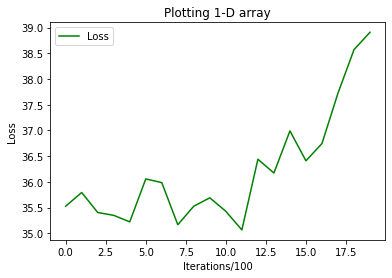

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(0,len(arr)))
y = np.array(arr)
plt.title("Plotting 1-D array")
plt.xlabel("Iterations/100")
plt.ylabel("Loss")
plt.plot(x, y, color = "green", label = "Loss")
plt.legend()
plt.show()

In [ ]:
c=0
s=0
for data,labels in test_iter:
  c+=1
  if model.predict(data)==labels:
    s+=1
  if(c==10000):
    break
print("Accuracy is: ",s/c)

Accuracy is:  0.5183
